# Assignment 1: Twitter sentiment and stock prices

**Deadline**:  18/09/2018, 4.59pm

|  |**Name**|**Student ID**|**Email**|
|:-|:-------|:-------------|:--------|
|1.|        |              |         |
|2.|        |              |         |
|3.|        |              |         |

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
3. Most of your answers will consist of code. Make sure your code is well structured, efficient and provided with comments where needed. These aspects will be taken into account in the grading of your work.
4. Sometimes your are asked to explain your code or to motivate your choices. Please be concise and use your own words in answering those questions.
5. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together.
6. Your work will be graded according to the following criteria: correctness of the solution, quality of the code (structure, efficiency) and quality of your arguments, reasoning and comments. For each exercise, you can earn 0, 1, 2 or 3 points. For some (larger) exercises this number is multiplied by a factor, which is explicitely mentioned in the exercises.

## Description
The goal of this assignment is to investigate the relation between real-time Twitter sentiments about publicly listed companies and their stock prices. One can do this by using machine learning algorithms to interpret tweets addressed to a company (via the @username syntax) and categorize the sentiment of the tweet as positive, neutral or negative. Subsequently, the relation between the aggregate sentiment over a certain time period and fluctuations in the stock price can be analyzed.

## Part 1: cleaning, preparing and analyzing Twitter sentiment data
This part of the assignment deals with cleaning, preparing and analyzing Twitter sentiment data for six airline companies:

|**Name Airline**|**@username**|
|:-------|:-------------|
|American Airlines       |@AmericanAir           |
|JetBlue Airways        |@JetBlue              |
|Southwest Airlines       |@SouthwestAir           |
|United Airlines        |@united              |
|US Airways        |@USAirways              |
|Virgin America       |@VirginAmerica             |

The dataset `airline_twitter_sentiment.csv` consists of more than 14.000 tweets sent on 9 consecutive days in February 2015, all addressing one (or more) of the aforementioned airlines via the @username syntax. The text of the tweets can be found in the `text` column of the dataset. Furthermore, a machine learning algorithm has analyzed the content of the tweets and categorized the sentiment as positive, neutral or negative. This can be found in the `airline_sentiment` column. The machine learning algorithm also estimates the probability that it identified the correct sentiment, which is given in the `airline_sentiment:confidence` column. Another relevant column is called `tweet_created`, giving the time and day at which the tweet was sent.

Our goal is to create for each airline a table with the number of positive, neutral and negative tweets for each hour during the 9 days for which we have data, and to extract some basic insights from the results.

(Note: US Airways was integreted into American Airlines in October 2015. Since our dataset is from February 2015, we will consider them as separate airlines.)

**Exercise 1:** import the relevant libraries.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import Counter
from fuzzywuzzy import fuzz

### Below we create all functions necessary for this assignment

In [2]:
def verschil(before, after):
    """
    Input 'before' should be a df before modifications
    Input 'after' should be a df after dropping some observations
    This function calculates the amount of dropped obeservations
    Return is the number of dropped observations 
    """
    print('The number of discarded obseravtions is given by: ', len(before) - len(after))
    return after

def companyname(text):
    company = [word for word in text.split() if word.startswith('@')]
    return company

**Exercise 2:** import the dataset `airline_twitter_sentiment.csv` and turn it into a DataFrame called `df`. Print the total number of tweets in the dataset.

In [3]:
df = pd.read_csv('airline_twitter_sentiment.csv')
amount_tw = len(df)
print("The total number of tweets is: " + str(amount_tw))

The total number of tweets is: 14694


**Exercise 3:** during the creation of the dataset some lines were duplicated. Remove them from `df`. Count the total number of duplicates and report on the number by printing it in a sentence that conveys the meaning of the number.

In [4]:
df = verschil(df, df.drop_duplicates(subset=None, keep='first', inplace=False))

The number of discarded obseravtions is given by:  54


**Exercise 4:** the machine learning algorithm is not always able to extract a sentiment from the tweet. This is reflected in a missing `airline_sentiment` value or a low probability in the column `airline_sentiment:confidence`. First, remove the lines with a missing airline sentiment from the `df`. As in the previous exercise, report on the number of discarded values.

In [5]:
print(Counter(df['airline_sentiment']))
print(Counter(df['airline_sentiment'])['negative']) 
df = verschil(df, df.dropna(subset=['airline_sentiment']))

Counter({'negative': 9155, 'neutral': 3088, 'positive': 2361, nan: 36})
9155
The number of discarded obseravtions is given by:  36


**Exercise 5 [factor 2]:** secondly, analyze the probabilities in the column `airline_sentiment:confidence` and propose a criterium for removing data with low probabilities. Your answer should have two parts: 
* a cell with code that is analyzing the data and printing/plotting the relevant results.
* a markdown cell where you explain your criterium and give a clear data-driven motivation for your choice.

## Below we show a histogram of the airline_sentiment:confidence to illustrate what confidence could be a low probability.

<function matplotlib.pyplot.show(*args, **kw)>

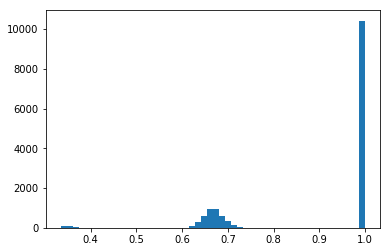

In [6]:
plt.hist(df['airline_sentiment:confidence'],50)
plt.show

In the overall histogram one sees peaks around confidences 0.33, 0.66 and 1.0. There seems to be an intuitive explanation for this, because there are three possible answers: positive, neutral, negative. 
* For confidences around 1.0, the algorithm seems sure (71% of the data). We will include these tweets in our analysis. 
* For confidences around 0.66, accounting for 27% of the data, the algorithm finds it hard to choose between 2 of the 3 options (probably between positive and neutral, or negative and neutral). Since we do not want to lose 27% of the tweets, whose sentiments probably are not altogether wrong (positive instead of negative, and vice versa), we will include these tweets in the analysis as well.
* For confidences around 0.33, the algorithm choses more or less randomly (2% of the data) out of the three available options. These sentiments are unreliable and cannot be used in our analysis. Luckily, this is the case for only 2% of all tweets, which means that we do not lose much data.

Based on the considerations above, our criterium is to discard all data below a confidence value of 0.5.

**Exercise 6:** remove the lines from `df` with an airline-sentiment confidence that is too low according to your criterium. Report on the number of discarded tweets.

In [7]:
df = verschil(df, df[df['airline_sentiment:confidence']>0.5])

The number of discarded obseravtions is given by:  235


**Exercise 7 [factor 2]:** crucially, what is still missing is the airline company that is being addressed in the tweet. This is done with the use of the @username syntax, which is called a mention. We have to extract this information from the text of the tweet. This can be done using regular expressions, for instance. Create a new column `mentions` in the `df`, whose values are a list of all the @username occurences (string type) in the text of a tweet. Furthermore, do the following:
* create a markdown cell where you carefully explain your approach for extracting the mentions from the tweet and the choices you have made.
* print the total number of mentions you have extracted from all tweets, and the average number of mentions per tweet.
* draw a random sample of 15 entries of the `mentions` column and print the sample (as a Series).

## Below we do something

In [8]:
capitalizer = lambda x: companyname(x)
df["mentions"] = df["text"].apply(capitalizer)
count_mentions = [len(mentions) for mentions in df["mentions"]]
print("The total number of mentions from all tweets is: ", sum(count_mentions))
print("The average number of mentions per tweet is: ", np.mean(count_mentions))

df["mentions"] = df["mentions"].apply(lambda y: np.nan if len(y) == 0 else y)
print("This is a row with no mention: ", df["mentions"][630])
df = verschil(df, df.dropna(subset=['mentions']))

df["mentions"].sample(n=15)

The total number of mentions from all tweets is:  15953
The average number of mentions per tweet is:  1.110237316445125
This is a row with no mention:  nan
The number of discarded obseravtions is given by:  188


12345     [@AmericanAir]
14041       [@USAirways]
890       [@AmericanAir]
2501     [@SouthwestAir]
9027         [@JetBlue:]
4646        [@USAirways]
7824     [@SouthwestAir]
6959        [@USAirways]
12482    [@SouthwestAir]
14253          [@united]
3307           [@united]
7814        [@USAirways]
12011       [@USAirways]
11435         [@JetBlue]
6630          [@JetBlue]
Name: mentions, dtype: object

Explanation of our regular expressions:
* the first part finds all mentions ending on a whitespace (`\s`), the second part does the mentions at the end of a line (`$`).
* optional non-alphanumeric symbols (`\W`) at the end of a mention are removed by `\W?`.
* we are using `\S` instead of `.`, because we decided to discard mentions that start with a whitespace after the @-symbol. By doing this, it could be that we are missing a few mentions with typos, but we expect this number to be very low. 

**Exercise 8 [factor 2]:** next, add another new column called `airline` to the `df` by initially filling the column with empty strings `''`. We want to use the mentions in the `mentions` columns to identify which airline is being addressed and put the name of this airline in the newly created `airline` column. For tweets with a single mention that exactly matches (up to differences in lowercase/uppercase letters) the username of an airline, it is unambiguous and relatively simple to do this. 

For those tweets, replace the empty string in the `airline` column by the official username (string type) of the addressed airline company, as specified in the table at the beginning of the assignment. Furthermore, report for which percentage of tweets you have identified the airline using this approach.

In [9]:
def strip(tweetmention):
    """
    We are going to strip all unrelevant text of the mentions, like symbols, interpunction, capital letters etc.
    """
    tweetmention = str(tweetmention)
    tweetmention = tweetmention.lower()
    tweetmention = "".join(l for l in tweetmention if l not in string.punctuation)
    return tweetmention

def NameAirline(x):
    """
    Input is the string airline name stripped from interpunction and small letters
    Output is the match to one of the airline usernames, or it notifies that no airline username was found.
    """
#     df["airline"][1][0:2] returns first two letters of second row "airline" column.
    x = str(x)
    if x[0:11] in 'americanair':
        y = "@AmericanAir"
    elif x[0:7] in 'jetblue':
        y = "@JetBlue"
    elif x[0:12] in 'southwestair':
        y = "@SouthwestAir"
    elif x[0:6] in 'united':
        y = "@united"
    elif x[0:9] in 'usairways':
        y = "@USAirways"
    elif x[0:13] in 'virginamerica':
         y = "@VirginAmerica"
    else:
         y = "NO_AIRLINE_USERNAME"
    return y

def findbestmatch(xlist):
    """
    Input should be a list with more than 1 item, so len(x)>1 (so more than one username),
    this function will keep the username item with higest similarity ratio and places it in airline username column
    """
    l = len(xlist)
    AirlineUsernames = ['@americanair','@jetblue','@southwestair','@united','@usairways','@virginamerica']
    a = []
    for item in xlist:
        a.append(fuzz.ratio(item.lower(), AirlineUsernames[0]))
    for item in xlist:
        a.append(fuzz.ratio(item.lower(), AirlineUsernames[1]))
    for item in xlist:
        a.append(fuzz.ratio(item.lower(), AirlineUsernames[2]))
    for item in xlist:
        a.append(fuzz.ratio(item.lower(), AirlineUsernames[3]))
    for item in xlist:
        a.append(fuzz.ratio(item.lower(), AirlineUsernames[4]))
    for item in xlist:
        a.append(fuzz.ratio(item.lower(), AirlineUsernames[5]))
    if max(a) > 85:
        username = AirlineUsernames[a.index(max(a))//l]
    else:
        username = "NO_AIRLINE"
    return username

In [10]:
df["mentions"][7495]

['@SouthwestAir', '@Sagerooski', '@']

In [11]:
df["airline"] = ""
df["mentions"] = df["mentions"].apply(lambda x: strip(x) if len(x) == 1 else strip(findbestmatch(x)))
df["airline"] = df["mentions"].apply(NameAirline)
# df.head(150)

**Exercise 9 [factor 3]:** for the other tweets, we are facing the following potential issues:
* mentions may contain typos.
* tweets may contain variations on the official username of the airline.
* some tweets do not address any airline.
* some tweets address multiple airlines.

Your task is to do the following:
* write a code that identifies for as many tweets as possible which (unique) airline is being addressed. For those tweets for which this is possible, assign the official username of the airline company to the column `airline` (as in the previous exercise). 
* create a markdown cell in which you give a detailed explanation of your approach and motivate the choices you have made.
* compute for which percentage of all tweets you have identified a (unique) airline.
* delete all tweets without uniquely identified airline from the DataFrame `df`.

(Hint: for this exercise you may want to use the package `fuzzywuzzy`, which can be installed using Anaconda with the command line `conda install -c conda-forge fuzzywuzzy`. In your Jupyter notebook, you only need to import fuzz: `from fuzzywuzzy import fuzz`. This module quantifies the similarity of two string expressions. For example, `fuzz.ratio('Twitter is cool','Twitter is cool') = 100`, while `fuzz.ratio('Twitter is cool','Twitter is not so cool') = 81`.)

In [12]:
df = df[~df['airline'].isin(['NO_AIRLINE_USERNAME'])]
Counter(df['airline'])

Counter({'@VirginAmerica': 476,
         '@united': 3680,
         '@SouthwestAir': 2335,
         '@USAirways': 2687,
         '@JetBlue': 2043,
         '@AmericanAir': 2870})

**Exercise 10:** before starting the analysis of the data, apply the following manipulations to `df`:
* delete the column `mentions`, which has become obsolete.
* sort the rows by airline and then by the day and time when the tweet was created, starting with the first tweet.
* reset the index and make sure the old index is dropped from the DataFrame.

In [26]:
df.drop(['mentions'], axis=1)
df.sort_values(by=['airline','tweet_created'])
df.reset_index(drop=True,inplace=False)
df


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline_sentiment_gold,...,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,mentions,airline
0,681448223,False,finalized,3,2/25/15 1:57,negative,1.0000,Customer Service Issue,1.0000,NaN,...,NaN,0,"@VirginAmerica help, left expensive headphones...","[33.94209449, -118.40410103]",2/23/15 21:10,5.700880e+17,Washington DC,Quito,virginamerica,@VirginAmerica
1,681452067,False,finalized,3,2/25/15 0:41,negative,1.0000,Flight Booking Problems,0.6939,NaN,...,NaN,0,@united very exasperating I'm having a difficu...,"[41.86591215, -87.6231126]",2/20/15 21:36,5.690080e+17,"Chicago, IL",Central Time (US & Canada),united,@united
2,681451479,False,finalized,3,2/25/15 4:43,neutral,1.0000,NaN,NaN,NaN,...,NaN,0,@united Can you help me get a flight out tonig...,NaN,2/21/15 16:58,5.693000e+17,"Oxford, MS",NaN,united,@united
3,681456798,False,finalized,3,2/25/15 3:27,negative,1.0000,Flight Booking Problems,1.0000,NaN,...,NaN,0,"@SouthwestAir 4/9/14, I need to fly from GSP t...",NaN,2/17/15 12:37,5.677850e+17,"Des Moines, Iowa",Central Time (US & Canada),southwestair,@SouthwestAir
4,681461929,False,finalized,3,2/25/15 3:50,negative,1.0000,Damaged Luggage,0.6663,NaN,...,NaN,0,"@USAirways Oh yes, because I had loads of time...",NaN,2/21/15 1:54,5.690730e+17,Raxacoricofallapatorius,Amsterdam,usairways,@USAirways
5,681453541,False,finalized,3,2/25/15 9:04,neutral,1.0000,NaN,NaN,NaN,...,NaN,0,@united i now see it's 72 hours. Thanks,NaN,2/18/15 17:50,5.682260e+17,NaN,Eastern Time (US & Canada),united,@united
6,681457766,False,finalized,3,2/25/15 7:40,positive,1.0000,NaN,NaN,NaN,...,NaN,0,@JetBlue ok thanks. Safety first.,NaN,2/22/15 19:57,5.697080e+17,Planet Brooklyn,Atlantic Time (Canada),jetblue,@JetBlue
7,681455921,False,finalized,3,2/25/15 0:59,neutral,1.0000,NaN,NaN,NaN,...,NaN,0,@SouthwestAir when can I start Flight Booking ...,NaN,2/19/15 13:12,5.685180e+17,NaN,NaN,southwestair,@SouthwestAir
8,681452831,False,finalized,3,2/25/15 2:38,neutral,0.6709,NaN,0.0000,NaN,...,NaN,0,@united LGJW7B. I voluntarily rerouted; 1st le...,NaN,2/19/15 18:06,5.685930e+17,NaN,NaN,united,@united
9,681454491,False,finalized,3,2/25/15 2:03,negative,1.0000,Customer Service Issue,0.6804,NaN,...,NaN,0,"@SouthwestAir customer service at FLL, BWI,and...",NaN,2/24/15 4:29,5.701990e+17,South Florida,NaN,southwestair,@SouthwestAir


**Exercise 11 [factor 2]:** find the total number and relative frequency of positive, neutral and negative tweets, split by airline. Present your answer in a DataFrame and create a visualisation of the results. For this exercise, most points are allocated to the quality of the visualization (e.g. axes, labeling, legend, titles). (Hint: one option is to use the `groupby` method.)

**Exercise 12:** give the three most frequently mentioned reasons for a negative tweet, split by airline. Present your results in the form of a DataFrame, where the airline usernames are the row indices and the columns names are `Reason 1`, `Reason 2` and `Reason 3`.

**Exercise 13:** eventually, we would like to investigate the relation between Twitter sentiment and stock price. Therefore, create a DataFrame called `df_by_hour` consisting of 18 columns. The index should represent time periods of exactly one hour. Then for each airline, we want three columns representing the total number of positive, neutral and negative tweets during that specific time interval of exactly one hour. Make sure the rows of the DataFrame are sorted by time interval, starting with the earliest interval. (Hint: create a DataFrame with a MultiIndex.)

**Exercise 14:** For each airline add a fourth column to your DataFrame, respresenting the `sentiment_polarity`, which is given by

$$ P_h = \frac{tw^+_h-tw^-_h}{tw^+_h+tw^-_h} \,, $$

where $tw^\pm_h$ is the number of positive/negative tweets during a one-hour time-interval $h$. Make sure that the order of columns of the DataFrame is logical, i.e. the column `sentiment_polarity` of an airline should be adjacent to the other three columns for that specific airline.

## Part 2: analyzing the relation between Twitter sentiment and stock prices

This part of the assignment is devoted to the relation between Twitter sentiment data and stock prices. You are given the daily sentiment polarity data of the 30 funds in the Dow Jones Index, covering a period of approximately 16 months in 2013 and 2014. You will be asked to analyze the correlation between Twitter sentiment polarity and the daily stock return.

**Exercise 15:** from the file `Twitter_sentiment_data.zip` on Canvas, import the Twitter sentiment data of your favorite company in the Dow Jones Index. Also import daily stock (closing) price data for your company of choice, covering the same period as the Twitter data. The stock price data should be imported directly from the internet, either through an API (e.g. use Quandl) or via web scraping (e.g. from Yahoo Finance).

(Note: if you do not manage to obtain the stock price data from the internet, you may continue the rest of the assignment with the Twitter and stock price data of Nike (NKE), which both can be found on Canvas. If you do this, you won't get any points for this exercise.)

**Exercise 16:** merge the data into a single `df`, each row representing a single day. Note that the Twitter data includes weekends and other non-trading days. For now, include those days in `df`.

**Exercise 17:** create a column `sentiment_polarity_lag_0`, which calculates the sentiment polarity for each day, and add it to your `df`.

**Exercise 18:** create a column that quantifies the daily return on the stock price. You can take (for example) the ratio of the closing price today and the closing price of the previous trading day. Explain in a markdown cell which quantity you have chosen.

**Exercise 19:** calculate the (Pearson) correlation between the daily sentiment polarity and the daily return on the stock price. Also calculate the p-value for this correlation. Before doing this, you need to decide on how to handle the Twitter sentiment data of non-trading days. One way of dealing with this is simply ignoring these days, but you may want to come up with a more advanced strategy. Motivate your decision and approach in a markdown cell.

**Exercise 20:** create a scatter plot of the daily sentiment polarity versus the daily return on the stock price.

**Exercise 21:** we would like to investigate how Twitter sentiment aggregated over a longer period correlates with the daily return on the stock price. For this purpose, add columns `sentiment_polarity_lag_i` to your dataframe, which should represent the aggregated sentiment polarity taking all positive and negative tweets today and in the previous `i` days into account. Choose the range and step size of the index `i` sensibly and motivate your choice in a markdown cell.

**Exercise 22:** calculate the correlations between the aggregated sentiment polarities and the daily return. Plot the results as a function of the lag included in the sentiment polarity (the index i) and also plot the p-values of the correlations. Interpret the results and discuss your findings in a markdown cell.